In [ ]:
import pandas as pd
import json
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,InputLayer,GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM ,GRU ,SimpleRNN ,Embedding ,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
data =  pd.read_csv('/content/drive/MyDrive/conv/lodale.csv')

In [ ]:
data

,Unnamed: 0,log,error
0,0,RAS KERNEL INFO instruction cache parity erro...,1
1,1,RAS KERNEL INFO instruction cache parity erro...,1
2,2,RAS KERNEL INFO instruction cache parity erro...,1
3,3,RAS KERNEL INFO instruction cache parity erro...,1
4,4,RAS KERNEL INFO instruction cache parity erro...,1
...,...,...,...
4152654,4152654,RAS KERNEL FATAL data TLB error interrupt,0
4152655,4152655,RAS KERNEL FATAL data TLB error interrupt,0
4152656,4152656,RAS KERNEL FATAL data TLB error interrupt,0
4152657,4152657,RAS KERNEL FATAL data TLB error interrupt,0


In [ ]:
data = data.drop('Unnamed: 0',axis=1)

In [ ]:
len(data[data['error']==0]['log'].unique())

2171

In [ ]:

total_normal_log = data[data['error']==1]['log'].unique()

In [ ]:
total_abnormal_log =data[data['error']==0]['log']

In [ ]:
total_log =np.append( total_normal_log,total_abnormal_log)

In [ ]:
total_error = np.append(np.ones((len(total_normal_log), 1)), np.zeros((len(total_abnormal_log), 1)), axis=0)

In [ ]:
df = pd.DataFrame({'log': total_log, 'error': list(total_error)}, columns = ['log','error'])

In [ ]:
df_train ,df_test  = train_test_split(df , test_size = 0.2,stratify=df['error'])

In [ ]:
df_val ,df_test  = train_test_split(df_test , test_size = 0.5)

In [ ]:
train_np = np.array(df_train['error']).astype(np.int)
test_np = np.array( df_test['error']).astype(np.int)
train_np = tf.convert_to_tensor(train_np)
test_np = tf.convert_to_tensor(test_np)
val_np = np.array( df_val['error']).astype(np.int)
val_np = tf.convert_to_tensor(val_np)


<ipython-input-23-418f90747feb>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_np = np.array(df_train['error']).astype(np.int)
<ipython-input-23-418f90747feb>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

In [ ]:
max_vocab_size = 10000
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(df['log'])
sequences_train =tokenizer.texts_to_sequences(df_train['log'])
sequences_test = tokenizer.texts_to_sequences(df_test['log'])

In [ ]:
sequences_val = tokenizer.texts_to_sequences(df_val['log'])

In [ ]:
word_index = tokenizer.word_index
v = len(word_index)
v

233771

In [ ]:
train_data = pad_sequences(sequences_train)
train_data.shape
train_data = tf.convert_to_tensor(train_data)

In [ ]:
T = train_data.shape[1]

In [ ]:
test_data = pad_sequences(sequences_test ,maxlen= T)
test_data.shape
test_data = tf.convert_to_tensor(test_data)

In [ ]:
val_data = pad_sequences(sequences_val ,maxlen= T)
val_data.shape
val_data = tf.convert_to_tensor(val_data)

In [ ]:
emb= 40
K =2



In [ ]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
embeding = []
for ll in df['log']:
  embeding.append(embed([ll]))

In [ ]:
emb = np.array(embeding)
emb=emb.reshape(338460,512)

array([[-0.00493155, -0.01847447, -0.03543668, ...,  0.06579278,
        -0.00443449, -0.06133293],
       [-0.01964419, -0.00570731, -0.00553881, ...,  0.03170839,
         0.04093323, -0.09645946],
       [ 0.01829919,  0.03213202, -0.02119564, ...,  0.05103691,
         0.03279664, -0.07944331],
       ...,
       [-0.00744484,  0.03530394, -0.04008177, ...,  0.04673046,
         0.03477227, -0.07184246],
       [-0.00744485,  0.03530394, -0.04008177, ...,  0.04673046,
         0.03477227, -0.07184246],
       [-0.00744485,  0.03530394, -0.04008177, ...,  0.04673046,
         0.03477227, -0.07184246]], dtype=float32)

In [ ]:
emb=emb.reshape(338460,512)
emb.shape

(338460, 512)

In [ ]:
uni_emb_data = pd.DataFrame(emb)

In [ ]:
uni_emb_data['error'] = df['error']

In [ ]:

uni_emb_data

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,error
0,-0.004932,-0.018474,-0.035437,-0.009774,0.037055,-0.069921,-0.041327,0.007592,0.041493,0.075260,...,0.018977,0.033009,0.035165,0.014623,-0.042760,-0.048367,0.065793,-0.004434,-0.061333,[1.0]
1,-0.019644,-0.005707,-0.005539,-0.087540,0.024261,0.002107,0.012216,-0.016988,0.003096,0.035258,...,0.024574,0.030605,-0.027119,0.054535,-0.003038,-0.000016,0.031708,0.040933,-0.096459,[1.0]
2,0.018299,0.032132,-0.021196,-0.023114,0.052901,-0.081266,-0.004286,-0.027320,0.043951,0.036480,...,0.012343,0.056036,-0.010923,0.003823,-0.057407,-0.013487,0.051037,0.032797,-0.079443,[1.0]
3,0.036031,0.036511,-0.025956,-0.020340,0.053479,-0.081265,-0.018866,-0.029045,0.033180,0.054014,...,0.017993,0.065929,-0.009925,0.010191,-0.059999,-0.005840,0.044389,0.043014,-0.076832,[1.0]
4,0.021419,0.046717,-0.032321,-0.011931,0.037876,-0.086089,-0.016719,-0.016340,0.035126,0.042744,...,0.025660,0.071387,-0.039773,0.016572,-0.037923,-0.021181,0.064452,0.045331,-0.075804,[1.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338455,-0.007445,0.035304,-0.040082,-0.055593,0.045006,-0.075279,-0.036121,-0.031008,-0.013901,0.069895,...,0.060853,-0.012150,-0.043362,0.005030,-0.023818,-0.026162,0.046730,0.034772,-0.071842,[0.0]
338456,-0.007445,0.035304,-0.040082,-0.055593,0.045006,-0.075279,-0.036121,-0.031008,-0.013901,0.069895,...,0.060853,-0.012150,-0.043362,0.005030,-0.023818,-0.026162,0.046730,0.034772,-0.071842,[0.0]
338457,-0.007445,0.035304,-0.040082,-0.055593,0.045006,-0.075279,-0.036121,-0.031008,-0.013901,0.069895,...,0.060853,-0.012150,-0.043362,0.005030,-0.023818,-0.026162,0.046730,0.034772,-0.071842,[0.0]
338458,-0.007445,0.035304,-0.040082,-0.055593,0.045006,-0.075279,-0.036121,-0.031008,-0.013901,0.069895,...,0.060853,-0.012150,-0.043362,0.005030,-0.023818,-0.026162,0.046730,0.034772,-0.071842,[0.0]


In [ ]:
uni_emb_data.to_csv('/content/drive/MyDrive/conv/google_emb.csv')

In [ ]:
features = emb
target = df['error']

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5
)

NameError: ignored

In [ ]:
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=x_train.shape[1]))
model.add(Embedding(v+1,emb) )
model.add(LSTM(64, activation='relu',
                return_sequences=True))
model.add(GRU(64, activation='relu',
                return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(48, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.3))

model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))



In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
np.random.seed(42)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',

    metrics = ['acc',f1_m,precision_m, recall_m]
)

In [ ]:
r = model.fit(x_train , y_train, epochs = 5 ,
              validation_data = (x_val , y_val))

Epoch 1/5
 401/8462 [>.............................] - ETA: 1:22:15 - loss: 0.5178 - acc: 0.7910 - f1_m: 0.8817 - precision_m: 0.7910 - recall_m: 1.0000

KeyboardInterrupt: ignored

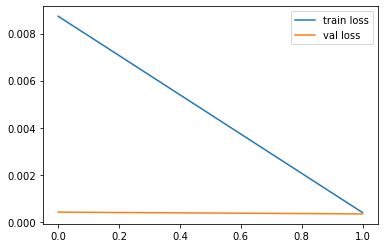

In [ ]:
plt.plot(r.history['loss'] , label = 'train loss')
plt.plot(r.history['val_loss'] , label= 'val loss')
plt.legend();

In [ ]:
pred = model.predict(x_test)

2116/2116 [==============================] - 53s 25ms/step


In [ ]:
pred

array([[9.999904e-01],
       [6.074500e-05],
       [9.999904e-01],
       ...,
       [9.999904e-01],
       [6.074500e-05],
       [9.999904e-01]], dtype=float32)

In [ ]:
bt = pd.DataFrame(pred , columns =['pred'] )

In [ ]:
for i in range (len(bt)):
            if (bt['pred'][i]<  0.5) :
               bt['pred'][i] =0
            else:
                bt['pred'][i] =1


In [ ]:
len(bt.pred.unique())

2

In [ ]:
bt.describe()

,pred
count,67692.000000
mean,0.791098
std,0.406566
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_test, pred, average=None)

array([0.99992928, 0.99998133])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(test_np, pred)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

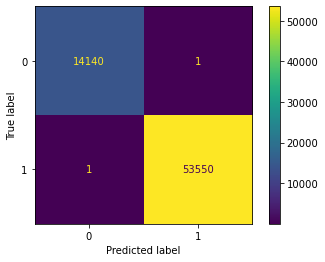

In [ ]:
disp.plot()

In [ ]:
fin_test = pd.read_csv('test_final.csv')

In [ ]:
sequences_pred = tokenizer.texts_to_sequences(fin_test['LOG'])

In [ ]:
final_test_data = pad_sequences(sequences_pred ,maxlen= T)
final_test_data.shape

(595300, 120)

In [ ]:

final_test_data = tf.convert_to_tensor(final_test_data)

In [ ]:
predict = model.predict(final_test_data)

 1575/18604 [=>............................] - ETA: 7:02

In [ ]:
len(predict)

In [ ]:
bdibt = pd.DataFrame(predict , columns =['label'] )

In [ ]:
for i in range (len(bdibt)):
            if (bdibt['label'][i]<  0.5) :
               bdibt['label'][i] ='abnormal'

            else:
                bdibt['label'][i] ='normal'


In [ ]:
bdibt

In [ ]:
bdibt.to_csv('submission2.csv')